In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from scipy.optimize import linear_sum_assignment
from cuml.manifold import TSNE
import torch
from torch import nn
import torch.optim as optim

pd.set_option('display.max_columns',None)
np.random.seed(42)

torch.manual_seed(42)
# torch.use_deterministic_algorithms(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/adisri/.opt/miniconda3/envs/rapids-22.10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
dataset = pd.read_csv("../data/covtype.csv")

# make targets 0-indexed
dataset['Cover_Type'] -= 1

print(f'Dataset Shape: {dataset.shape}')
display(dataset.head())

Dataset Shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4


## Dataset Analysis

### Data Cleaning

In [3]:
# checking for duplicates and invalid entries
duplicate = dataset[dataset.duplicated()]
print("Duplicates:",duplicate.shape[0])
determine_na_cols = list(dataset.isna().sum())
na_cols = []
for i, val in enumerate(determine_na_cols):
    if val>0:
        na_cols.append(dataset.columns[i])
if len(na_cols)>0 : print("NA's found in", na_cols)
else: print("None of the datapoints have any N/A value.")

Duplicates: 0
None of the datapoints have any N/A value.


### Creating Splits

In [4]:
feature_labels = [l for l in dataset.columns if l != 'Cover_Type']
numerical_labels = [l for l in dataset.columns if 'Wilderness_Area' not in l and not 'Soil_Type' in l and l != 'Cover_Type']
categorical_labels = [l for l in dataset.columns if ('Wilderness_Area' in l or 'Soil_Type' in l) and l != 'Cover_Type']
target_labels = ['Cover_Type']
dropped_labels = set()

X_train, X_test, y_train, y_test = train_test_split(dataset[feature_labels], dataset[target_labels], test_size=0.20, stratify=dataset[target_labels])

### Dataset Stats

In our dataset, the categorical features are `Soil_Type` and `Wilderness_Area`. All other features are numerical.

In [5]:
display(X_train.describe())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.510659,155.828564,14.104561,269.348360,46.420753,2351.817981,212.130135,223.316498,142.546121,1979.967905,0.448617,0.051354,0.436280,0.063749,0.005213,0.012861,0.008395,0.021275,0.002747,0.011381,0.000179,0.000321,0.001969,0.056247,0.021422,0.051750,0.029877,0.000983,0.000006,0.004871,0.005835,0.003212,0.006910,0.015989,0.001461,0.057297,0.099437,0.036555,0.000800,0.004408,0.001820,0.001620,0.198245,0.051789,0.044091,0.090745,0.077677,0.002777,0.003272,0.000194,0.000508,0.026725,0.023911,0.015226
std,280.025077,111.979785,7.487174,212.389447,58.232689,1559.332485,26.762907,19.768788,38.267028,1323.564719,0.497353,0.220720,0.495924,0.244305,0.072012,0.112676,0.091238,0.144301,0.052343,0.106073,0.013362,0.017901,0.044325,0.230398,0.144786,0.221523,0.170248,0.031341,0.002541,0.069621,0.076162,0.056584,0.082841,0.125434,0.038193,0.232409,0.299248,0.187666,0.028279,0.066248,0.042624,0.040217,0.398678,0.221601,0.205298,0.287246,0.267663,0.052629,0.057111,0.013914,0.022527,0.161279,0.152772,0.122449
min,1860.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1999.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

As we can see above,

1. The mean elevation is 2959.365 m whereas the median elevation is 2996.
2. The median aspect is 127 degree azimuth and the median slope is 13 degrees.
3. The average horizontal distance to hydrology is 269.428 m and average vertical distance to hydrology is 46.418 m
4. The maximum elevation is 3858 m.
5. The average horizonatal distance to roadways is 2350.146 m, minimum distance is 0 m and the maximum distance is 7117 m.

#### TSNE Visualization

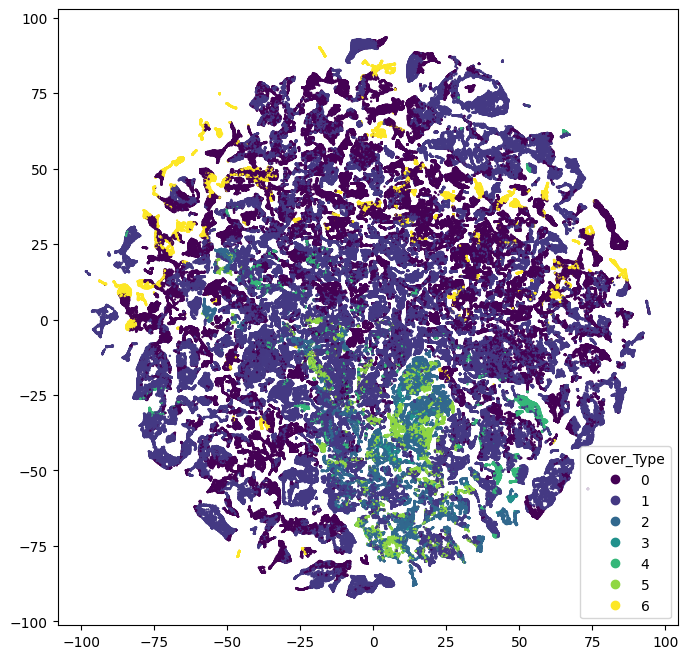

In [13]:
# reduce dimensionality to 2D with TSNE for visualization
# tsne    = TSNE(n_components=2, perplexity=300, n_neighbors=1000, learning_rate=20)
# tsne_2D = tsne.fit_transform(X_train)

# # plot scatterplot
fig = plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne_2D[:,0], tsne_2D[:,1], c = y_train['Cover_Type'], s = 0.5)
plt.legend(*scatter.legend_elements(), title="Cover_Type")

### Correlation Study

<AxesSubplot: >

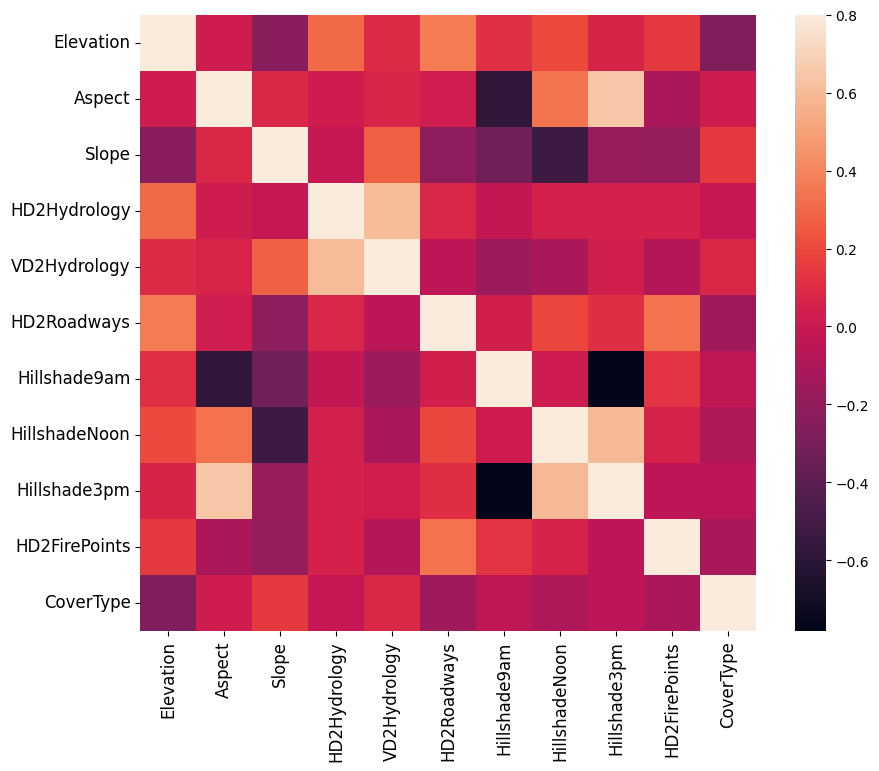

In [18]:
# checking correlations using Pearson's R
corrmatrix = pd.concat([X_train[numerical_labels], y_train], axis=1).corr()
f, ax = plt.subplots(figsize=(10,8))
axis_labels = ["Elevation", "Aspect", "Slope", "HD2Hydrology", "VD2Hydrology", "HD2Roadways", "Hillshade9am", "HillshadeNoon", "Hillshade3pm", "HD2FirePoints", "CoverType"]
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
display(sns.heatmap(corrmatrix, vmax=0.8, square = True, xticklabels=axis_labels, yticklabels=axis_labels))
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# display(corrmatrix)

Identifying highly correlated features;

In [7]:
corrmatrix = pd.concat([X_train[feature_labels], y_train], axis=1).corr()
high_corr_list = []
for i in range(len(feature_labels)+1):
    for j in range(i+1, len(feature_labels)+1):
        if abs(corrmatrix.iloc[i,j])>= 0.5:
            high_corr_list.append([corrmatrix.iloc[i,j],i,j])

# print the higher values
print("Correlation Values:")
cols = dataset.columns
for v,i,j in sorted(high_corr_list):
    print("\t", cols[i],"and", cols[j],f": {v: .2f}")

Correlation Values:
	 Wilderness_Area1 and Wilderness_Area3 : -0.79
	 Hillshade_9am and Hillshade_3pm : -0.78
	 Elevation and Wilderness_Area4 : -0.62
	 Aspect and Hillshade_9am : -0.58
	 Slope and Hillshade_Noon : -0.53
	 Wilderness_Area1 and Soil_Type29 :  0.55
	 Hillshade_Noon and Hillshade_3pm :  0.59
	 Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology :  0.61
	 Aspect and Hillshade_3pm :  0.65


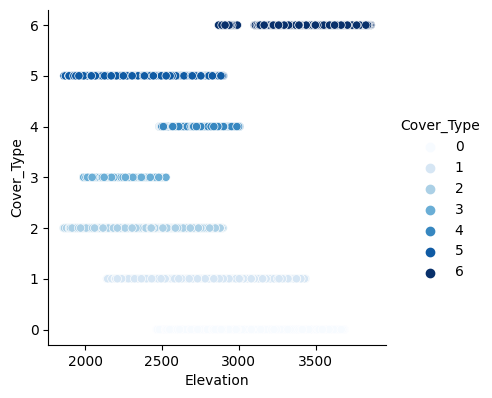

In [14]:
sns.pairplot(pd.concat([X_train,y_train],axis=1), hue="Cover_Type", height=4, palette = "Blues", x_vars=cols[0],y_vars=cols[-1] )
plt.show()

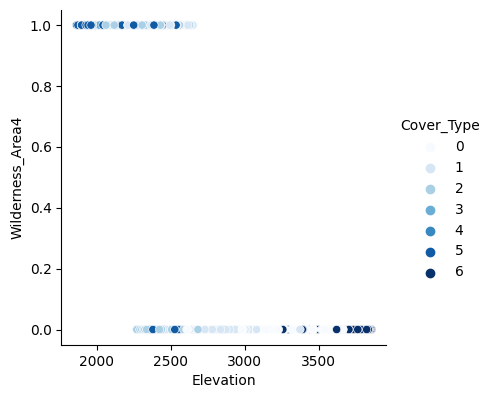

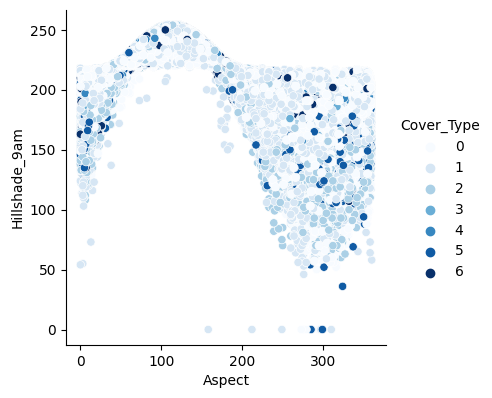

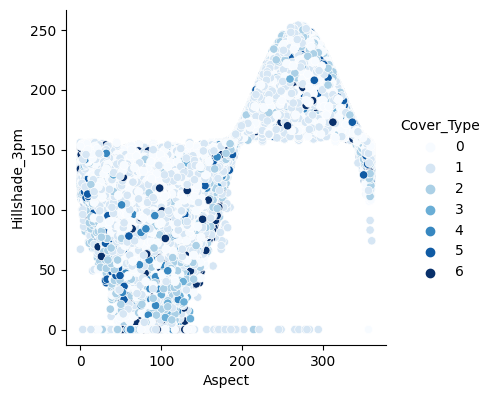

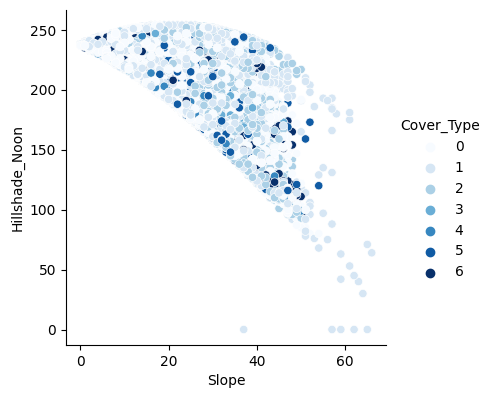

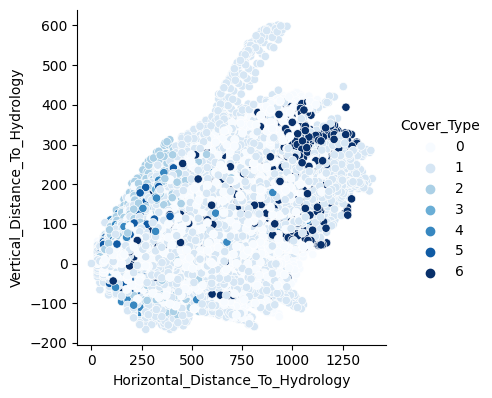

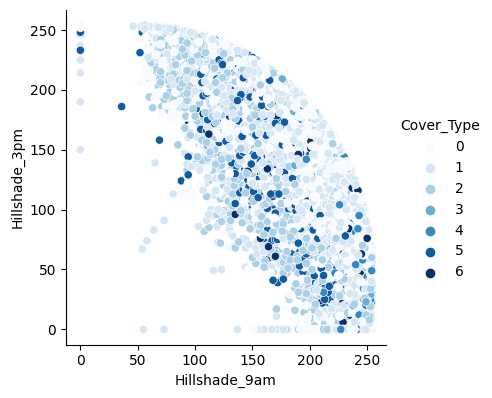

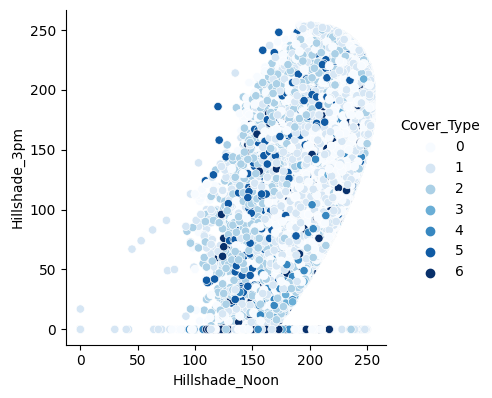

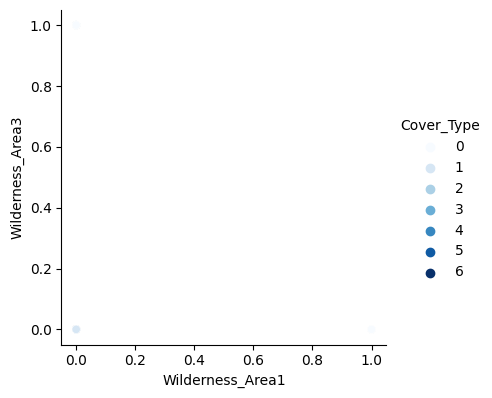

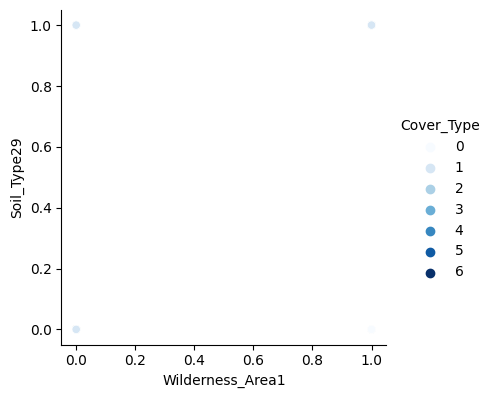

In [8]:
#Plotting a pair plot for the high correlated features
for v,i,j in high_corr_list:
    sns.pairplot(pd.concat([X_train,y_train],axis=1), hue="Cover_Type", height=4, palette = "Blues", x_vars=cols[i],y_vars=cols[j] )
    plt.show()

From the above graphs we can make the following inferences;
1. Hillshades have an ellipsoid pattern with each other
2. Hillshades and Aspect attributes show a sigmoid relationship
3. Wilderness_Area_1 and Elevation show a step function relationship
4. Wilderness_Area_1, Wilderness_Area_3, Soil_Type_29 map to a very small subset of Cover_Types

In [ ]:
for x_value in ["Soil_Type29","Wilderness_Area1", "Wilderness_Area3"]:
    sns.pairplot(pd.concat([X_train,y_train],axis=1), hue="Cover_Type", height=4, palette = "Blues", x_vars=x_value,y_vars="Cover_Type" )
    plt.show()

From the above figures we can make the following inferences;

1. Wilderness area 1 and soil type 29 both have Cover_types 2, 5 and 7 only
2. Wilderness area 3 has all cover types apart from Cover_Type 1 and 4

### Dataset Skew Study

In [19]:
# skew per label
def skew():
    skewness = X_train[numerical_labels].skew()
    skew_score = {"High":[],"Moderate":[],"Fair":[]}
    for i,skew in enumerate(skewness):
        if abs(skew)<=0.5:
            skew_score["Fair"].append(cols[i])
        elif abs(skew)<=1:
            skew_score["Moderate"].append(cols[i])
        else:
            skew_score["High"].append(cols[i])

    for k in skew_score:
        print(f"{k}: {skew_score[k]}")

skew()

High: ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']
Moderate: ['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways']
Fair: ['Aspect', 'Hillshade_3pm']


<AxesSubplot: xlabel='Cover_Type', ylabel='count'>

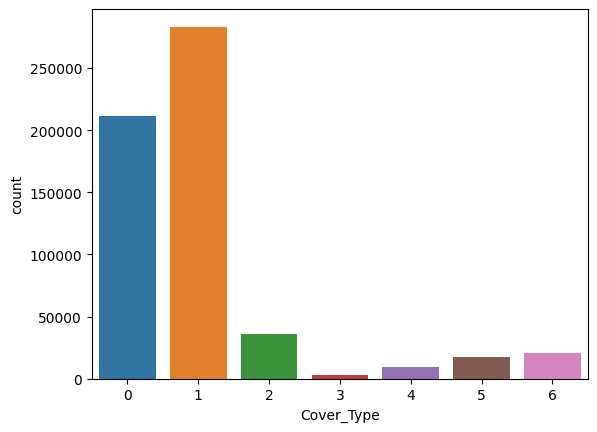

In [20]:
# skew in overall distribution of samples
plt.ylabel("# of Trees")
sns.countplot(data=dataset, x='Cover_Type')

### Standardization

In [21]:
def scale(scaler):
    X_train[numerical_labels] = scaler.fit_transform(X_train[numerical_labels])
    X_test[numerical_labels] = scaler.transform(X_test[numerical_labels])

scalers = [MinMaxScaler(), StandardScaler(), Normalizer()]
for scaler in scalers:
    scale(scaler)

In [22]:
# check skew after standardization
skew()

High: []
Moderate: ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
Fair: ['Elevation', 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']


### Feature Engineering

In [ ]:
# adding feature Euclidean_Distance_to_Hydrology
feature_labels.append("Euclidean_Distance_To_Hydrology")
numerical_labels.append("Euclidean_Distance_To_Hydrology")
X_train["Euclidean_Distance_To_Hydrology"] = ((X_train['Horizontal_Distance_To_Hydrology']**2)+(X_train['Vertical_Distance_To_Hydrology']**2))**0.5
X_test["Euclidean_Distance_To_Hydrology"] = ((X_test['Horizontal_Distance_To_Hydrology']**2)+(X_test['Vertical_Distance_To_Hydrology']**2))**0.5

X_train = X_train.drop(["Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology"], axis=1)
X_test = X_test.drop(["Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology"], axis=1)

In [ ]:
skew()

In [ ]:
# we get an unskewed extrapolation from two skewed columns

## Modeling

### Unsupervised: KMeans

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X_train, y_train)

accuracies = []
for fold, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_indices].to_numpy()
    y_train_fold = y_train.iloc[train_indices].to_numpy()
    X_val_fold = X_train.iloc[val_indices].to_numpy()
    y_val_fold = y_train.iloc[val_indices].to_numpy()

    kmeans = KMeans(n_clusters=7)
    kmeans.fit(X_train_fold)

    clusters = kmeans.predict(X_val_fold)
    clusters_uniq, labels_uniq = np.unique(clusters), np.unique(y_train_fold)
    matrix = np.zeros((len(clusters_uniq),len(labels_uniq)))
    for cluster, y in zip(clusters, y_val_fold):
        matrix[cluster][y] += 1
    imap, jmap = linear_sum_assignment(matrix, maximize=True)
    accuracy = (matrix[imap, jmap].sum())/X_val_fold.shape[0]
    accuracies.append(accuracy)

    print(f'Fold {fold} validation accuracy: {accuracy}', end='\r')

print(f'Mean training accuracy: {np.mean(accuracies)}')

In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train.to_numpy())

clusters = kmeans.predict(X_test.to_numpy())
clusters_uniq, labels_uniq = np.unique(clusters), np.unique(y_train)
matrix = np.zeros((len(clusters_uniq),len(labels_uniq)))
for cluster, y in zip(clusters, y_test.to_numpy()):
    matrix[cluster][y] += 1

imap, jmap = linear_sum_assignment(matrix, maximize=True)
accuracy = (matrix[imap, jmap].sum())/X_test.shape[0]
print(f'Test Accuracy: {accuracy}')

## Neural Network

In [ ]:
ohe = OneHotEncoder()
ohe.fit(y_train.values)

In [ ]:
X_train.shape, y_train_one_hot.shape

In [ ]:
# define model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense_stack = nn.Sequential(
            nn.Linear(X_train.shape[1], 55**2),
            nn.ReLU(),
            nn.Linear(55**2, 55**2),
            nn.ReLU(),
            nn.Linear(55**2, 512),
            nn.ReLU(),
            nn.Linear(512, y_train_one_hot.shape[1])
        )

    def forward(self, x):
        logits = self.dense_stack(x)
        return logits

In [ ]:
# training loop
BATCH_SIZE = 64
EPOCHS = 200
LR = 1e-3

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X_train, y_train)

accuracies = []
for fold, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_indices].to_numpy()
    y_train_fold = ohe.transform(y_train.iloc[train_indices].values).todense()
    X_val_fold = X_train.iloc[val_indices].to_numpy()
    y_val_fold = y_train.iloc[val_indices].to_numpy()

    # initialize model, loss and the optimizer
    model = Model().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    prev_accuracy = float('inf')
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for i in range(0, len(X_train_fold), BATCH_SIZE):
            X_batch = torch.Tensor(X_train_fold[i: i+BATCH_SIZE]).to(device)
            y_batch = torch.Tensor(y_train_fold[i: i+BATCH_SIZE]).to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            print(f"Fold {fold}, Epoch {epoch}, Batch Loss {loss.item()}", end='\r')

        with torch.no_grad():
            X_val_fold_tensor = torch.Tensor(X_val_fold).to(device)
            y_val_fold_tensor = torch.Tensor(ohe.transform(y_val_fold).todense()).to(device)

            outputs = model(X_val_fold_tensor)
            loss = criterion(outputs, y_val_fold_tensor)
            _, y_pred = torch.max(outputs, 1)
            f1 = f1_score(y_val_fold, y_pred.data.cpu(), average='weighted')
            ac = accuracy_score(y_val_fold, y_pred.data.cpu())
            if abs(ac-prev_accuracy)/prev_accuracy < 1e-5:
              accuracies.append(ac)
              break
        
        print(f"Fold {fold}, Epoch {epoch}, Epoch Loss {epoch_loss}, Val Loss {loss.item()}, Val F1 {f1}, Val Accuracy {ac}")

In [ ]:
# test model on test split
with torch.no_grad():
  X_test_tensor = torch.Tensor(X_test.to_numpy()).to(device)
  y_test_tensor = torch.Tensor(ohe.transform(y_test.values).todense()).to(device)

  outputs = model(X_test_tensor)
  loss = criterion(outputs, y_test_tensor)
  _, y_pred = torch.max(outputs, 1)
  f1 = f1_score(y_test, y_pred.data.cpu(), average='weighted')
  ac = accuracy_score(y_test, y_pred.data.cpu())
  print(f1, ac)

In [ ]:
ablation_study_results = {
    'Elevation': (0.9025127570212549, 0.9024637918126038), 
    'Aspect': (0.93696481754426, 0.9370584236207327), 
    'Slope': (0.9349954158436847, 0.9352254244726901), 
    'Horizontal_Distance_To_Hydrology': (0.9288429310936818, 0.9290723991635328), 
    'Vertical_Distance_To_Hydrology': (0.9312554714695024, 0.9315163980275897)
}

### XGBoost

In [ ]:
xg_cl = xgb.XGBClassifier(n_estimators=100, seed=0,subsample=0.25)
#Fit the model
xg_cl.fit(X_train,y_train)

#Predict the model
preds = xg_cl.predict(X_test)

#Accuracy
accuracy_xgbClassifier = np.mean(ytest == preds)
print("accuracy: %f" %(accuracy_xgbClassifier))